# Case Study: Math PhD Exchange

This data set is derived from the article ["Eigenvector-Based Centrality Measures for Temporal Networks
"](https://arxiv.org/abs/1507.01266) by Taylor, Myers, Clauset, Porter, and Mucha, which was in turn scraped from the [Mathematics Geneology Project](https://www.genealogy.math.ndsu.nodak.edu/). There is an entry $i\rightarrow j$ in year $t$ if a mathematician graduated in year $t$ from university $j$ and thereafter supervised at least one PhD thesis at university $i$. This is a proxy for hiring data: we are assuming, essentially, that this mathematician was hired ("endorsed") by $i$ in or around year $t$. 

## Data Limitations

There are several limitations in these data implied by the collection process. 

1. If a mathematician is hired in year $t$, then they are unlikely to show up in the data set until roughly year $t+\tau$, where $\tau\approx 5 \pm 2$ is the approximate amount of time required to complete a PhD thesis. 
2. If a mathematician is hired sequentially by departments $i$ and $i'$, both $i$ and $i'$ will be taken to have endorsed this mathematician *in the same year* $t$, even though the actual time in which $i'$ hired the mathematician may be well after $i$. This raises the potential for causality violations. 

To address limitation 1., we omit the final six years of the data set. We'll study the years 1960-2000. 

In [5]:
import numpy as np


from py.utils import *
from py.prep_data import *
from py.model import model
from py.scores import *
from numba import jit

import networkx as nx
# visualization

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial Unicode MS"

cset = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377']
cset_muted = ['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD','#000000']
from matplotlib.gridspec import GridSpec


# Data Preparation

First we read the data. In order to ensure connectedness of the endorsement matrix across many time periods, we restrict the data to only the top 100 schools by placement. 

In [6]:
data_dir = 'data/PhD Exchange Network Data/'

n = 70
T, labels, timesteps = prep_math_phd(data_dir, top_n = n) 

# T is a sequence of 61 matrices of size 100 x 100, one for each year 1946-2006 
# T.shape, timesteps

In order to ensure that the endorsement matrix is weakly connected at the initial condition, we are going to take all of the pre-1960 data and aggregate it into the initial state matrix. In order to address limitation 1) above, we are also going to exclude the years 2001-onward from analysis. 

In [7]:
T, timesteps, A0, n_obs = initial_condition(T, timesteps, t_start = 14, t_end = 55)
# timesteps # the years remaining in the data are: 

In [8]:
n_obs

6019.0

# Inference

Now we're ready to try to learn the model on some data. In the paper, the instantaneous rate of endorsements to $j$ is given by $\gamma_j \propto e^{\beta s_j}$. This rate is independent of the identity of the endorser. 

The model used here is an extension in two respects. First, we use a more general rate $\gamma$ that depends on the identity of both the endorser and the endorsed: 

$$\gamma_{ij} \propto e^{\beta_1s_j + \beta_2 (s_i - s_j)^2}$$

The incorporation of the quadratic term in the exponent governs a tendency for agents to endorse each other when they are nearby in the hierarchy. If $\beta_1$ is negative, endorsements that span large swaths of rank-space are discouraged. For example, in the context of faculty hiring, negative values of $-\beta_2$ would discourage cases in which a very low-ranked school was able to hire a candidate from a very high-ranked school. The model that we have been considering can be recovered by fixing $\beta_2 = 0$. 

Second, we also consider a version of this model in which, instead of $s_j$ denoting the SpringRank of $j$, we set $s_j = \sqrt{d_j}$. In this case, it doesn't matter "where" you are in the hierarchy, only the total number of endorsements you've received. 

The result of SpringRank-based inference is:

In [9]:
L_SR = model()

L_SR.set_score(
    score_function = lambda A: homebrew_SpringRank_score(A.T, alpha = .01)
)

def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

L_SR.set_features([
    linear_feature, 
    quadratic_feature
])

L_SR.set_data(T, A0)

pars_SR = L_SR.ML(lam0 = .8, 
           alpha0 = 10**(-4), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = True, 
           align = False)
pars_SR

computing memory hyperparameter lambda
Lambda = 0.8500000000000001, LL = 14968.794331305588
Lambda = 0.9000000000000001, LL = 14928.613309605451
Lambda = 0.9161792664439419, LL = 14926.866960419982
Lambda = 0.9096692792649266, LL = 14926.681341583833
Lambda = 0.9130046551730631, LL = 14926.616404480843
Lambda = 0.9114248476547802, LL = 14926.606307029899
Lambda = 0.9122060698140559, LL = 14926.601984533361
Lambda = 0.9118272640520446, LL = 14926.601818620944
computing parameter vector beta


{'lam': 0.9118272640520446,
 'beta': array([ 2.9903111 , -1.12242746]),
 'LL': -14926.601818620933}

In [10]:
L_RW = model()

L_RW.set_score(
    score_function = lambda A: RW_score(A, p = 0.75, alpha = 10**(-6))
)

def linear_feature(s):
    return(np.outer(np.ones(len(s)), s))

def quadratic_feature(s):
    S = linear_feature(s)
    V = (S - S.T)**2
    return(V)

L_RW.set_features([
    linear_feature, 
    quadratic_feature
])

L_RW.set_data(T, A0)

pars_RW = L_RW.ML(lam0 = .6, 
           alpha0 = 10**(-1), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = True, 
           align = False)
pars_RW

computing memory hyperparameter lambda
Lambda = 0.65, LL = 15385.583564571134
Lambda = 0.7000000000000001, LL = 15275.278519121526
Lambda = 0.7500000000000001, LL = 15175.78167374045
Lambda = 0.8000000000000002, LL = 15089.778535221736
Lambda = 0.8500000000000002, LL = 15022.475897429911
Lambda = 0.9000000000000002, LL = 14987.8095284392
Lambda = 0.9062500000000002, LL = 14987.26030579539
Lambda = 0.9060546875000002, LL = 14987.260274375603
computing parameter vector beta


{'lam': 0.9060546875000002,
 'beta': array([ 19.51820363, -52.54847837]),
 'LL': -14987.260274375603}

The result of degree-based inference is: 

In [11]:
# degree-based inference: this call should be faster

L_deg = model()

L_deg.set_score(
    score_function = lambda A: powered_degree_score(A, p = 0.5)
)

L_deg.set_features([
    lambda s: linear_feature(s), 
    lambda s: quadratic_feature(s)
])

L_deg.set_data(T, A0)

pars_deg = L_deg.ML(lam0 = .7, 
           alpha0 = 10**(-4), 
           tol = 10**(-3), 
           step_cap = .05,
           print_updates = False, 
           align = False)
pars_deg

computing memory hyperparameter lambda
computing parameter vector beta


{'lam': 0.8746063347171003,
 'beta': array([ 1.27657481, -0.18190079]),
 'LL': -14378.640319976104}

In [12]:
# pagerank!

L_PR = model()

    
L_PR.set_score(
    score_function = lambda A: A.shape[0]*PageRank_score(A + .01)
)


L_PR.set_features([
    linear_feature, 
    quadratic_feature
])

L_PR.set_data(T, A0)

pars_PR = L_PR.ML(lam0 = 0.8, 
                alpha0 = 10**(-2), 
                tol = 10**(-3), 
                step_cap = .05,
                print_updates = True, 
                align = False)
pars_PR

computing memory hyperparameter lambda
Lambda = 0.8500000000000001, LL = 15047.061514244553
Lambda = 0.9000000000000001, LL = 15019.846678544443
Lambda = 0.9500000000000002, LL = 15001.28601394764
Lambda = 0.9562500000000002, LL = 15001.018826008421
Lambda = 0.9546875000000001, LL = 15000.996544225673
Lambda = 0.9550781250000001, LL = 15000.996024577595
computing parameter vector beta


{'lam': 0.9550781250000001,
 'beta': array([ 0.73829567, -0.06663764]),
 'LL': -15000.996024577598}

These results suggest that the degree-based feature model may be preferable to the SpringRank model, based on its higher log-likelihood (LL). Other points to note are that the models give very similar estimates for $\lambda$, indicating that they agree on the relevant timescales for prediction in these data. 

Let's proceed with the degree-based parameters. 

In [14]:
# print the scores as a nice table

d = {
    'SpringRank': [L_SR, pars_SR],
    'Degree': [L_deg, pars_deg], 
    'PageRank': [L_PR, pars_PR]
}

# model_key = 'SR'

def make_pretty(model_key, n_obs):
    L = d[model_key][0]
    pars = d[model_key][1]

    H = L.estimate_hessian(pars['lam'], pars['beta'])
    V = np.linalg.inv(-H) # covariance matrix

    s_lam = np.sqrt(V[0,0])
    s_b1 = np.sqrt(V[1,1])
    s_b2 = np.sqrt(V[2,2])

    LL_string = 'Log-Likelihood = ' + str(np.around(pars['LL'], 0)) + ' on ' + str(n_obs) + ' observations.'

    lam = f"{pars['lam']:.2f}" + ' (' + f"{s_lam:.2f}" + ')'
    b1 = f"{pars['beta'][0]:.2f}" + ' (' + f"{s_b1:.2f}" + ')'
    b2 = f"{pars['beta'][1]:.2f}" + ' (' + f"{s_b2:.2f}" + ')'

    LL = f"{pars['LL']:.0f}"
    # n_obs = f"{n_obs:.0f}"
    return(lam, b1, b2, LL)

def print_pretty(model_keys = ("SpringRank", "Degree", "PageRank"), n_obs = 1):
    pars_dict = {}
    for model_key in model_keys:
        pars_dict[model_key] = make_pretty(model_key, n_obs)
    row_format = "{:<15}" + "{:>15}" * 3
    print(row_format.format("Parameter", *model_keys))

    for i in range(4):
        par_names = ['Lambda', 'Beta_1', 'Beta_2', 'LL']
        row = [pars_dict[model_key][i] for model_key in model_keys]
        print(row_format.format(par_names[i],*row))
        # print(row)
    print()
print_pretty(("SpringRank", "Degree", "PageRank"), n_obs = n_obs)

Parameter           SpringRank         Degree       PageRank
Lambda             0.91 (0.01)    0.87 (0.01)    0.96 (0.01)
Beta_1             2.99 (0.04)    1.28 (0.02)    0.74 (0.01)
Beta_2            -1.12 (0.04)   -0.18 (0.01)   -0.07 (0.00)
LL                      -14927         -14379         -15001



In [15]:
pars = pars_deg
L = L_deg

# Parameter Uncertainty

Now let's estimate the covariance matrix of the parameters by inverting the Hessian matrix of the likelihood function at the parameters we solved for. 

# Snapshot of model prediction

The mini-study below considers how the model ''works.'' 

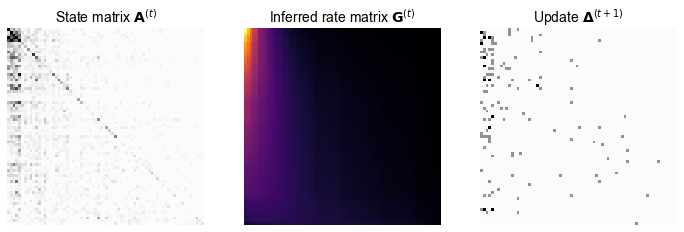

In [27]:
# snapshot of the state and cumulative hiring matrix at specified time i

# A = state_matrix(T, A0 = A0, lam = pars['lam'])

# S = SR_quadratic_feature(A)

pars = pars_SR
L = L_SR

i = 20

V = L.GAMMA[i]
# V = softmax(S, np.array([2.8, 0]))[i]

fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot(131)
ax.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(L.A[i], -V.sum(axis = 0)), vmax = .8,  cmap = 'Greys', alpha = .99)
ax.set(title = r'State matrix $\mathbf{A}^{(t)}$')
ax.axis('off')

ax = fig.add_subplot(132)
# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno')
ax.set(title = 'Inferred rate matrix $\mathbf{G}^{(t)}$')
plt.gca().axis('off')

ax = fig.add_subplot(133)
ax.imshow(np.ones_like(T[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+1]-T[i], -V.sum(axis = 0)), vmax = 2,  cmap = 'Greys', alpha = .99)
ax.set(title = 'Update $\mathbf{\Delta}^{(t+1)}$')
ax.axis('off')
# plt.colorbar()

plt.savefig('fig/math_phd_illustration.png', dpi = 300, bbox_inches = 'tight')

On the far left, we show the model state $A_t$ at time $t = 30$. Each entry of this matrix is a weighted sum of previous hiring events: $A_{ij}^{(t)} = \sum_{\tau = 1}^t \lambda^\tau E_{ij}^{(\tau)}$, where $E_{ij}^{(\tau)}$ is the number of times $i$ endorsed $j$ in time period $\tau$. This matrix is an input into the rate matrix $\Gamma$, which is shown in the center. This is a matrix of predictions about endorsements in the next time-step: entry $\gamma_{ij}$ is proportional to the predicted probability that $i$ will endorse $j$ in the next timestep. Finally, we can (heuristically) compare the rate matrix to the observed update at time $t+1$, noting that the bulk of endorsement events do indeed occur in regions of high probability specified by the rate matrix. 

# Inferred rank dynamics

Now let's visualize the evolution of this system as understood by the model. It's of possible interest to visualize at least two distinct objects. The first is the overall modeled endorsement rate, which predicts the rate of endorsements of $j$ in the next timestep. The second is the intrinsic ranks modeled for each individual school. 

I'd like to add two panels to this plot, in order to make it four panels in total. One panel (lower) could be just the counts of placements (i.e. sums of T) in each time period, which would be an interesting contrast with the "raw" data. What would the corresponding top panel be? 



In [20]:
shortener = {
    'Massachusetts Institute of Technology' : 'MIT',
    'University of California, Berkeley' : 'Berkeley', 
    'Stanford University' : 'Stanford',
    'Princeton University' : 'Princeton',
    'Harvard University' : 'Harvard',
    'Yale University' : 'Yale',
    'The University of Chicago' : 'Chicago',
    'California Institute of Technology' : 'Caltech',
    'Cornell University' : 'Cornell',
    'University of Michigan' : 'Michigan',
    'University of Wisconsin-Madison': 'Wisconsin-Madison'
}

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

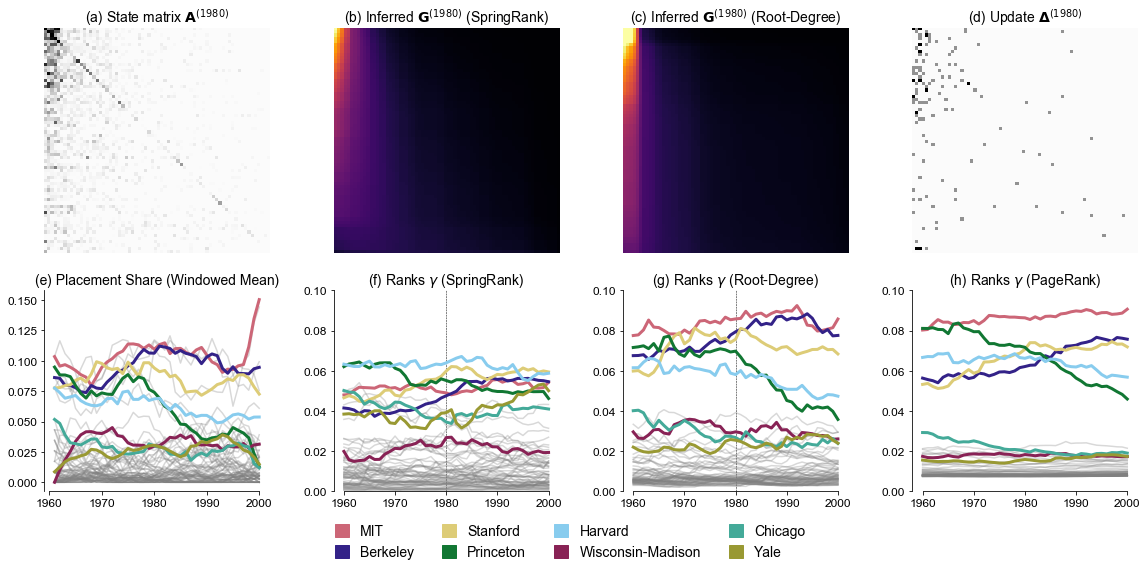

In [35]:
import matplotlib.patches as mpatches

highlight = ['MIT', 'Berkeley', 'Stanford', 'Princeton', 'Harvard', 'Wisconsin-Madison', 'Chicago',  'Yale']

fig, axarr = plt.subplots(2, 4, figsize = (16,8))

L = L_deg

# first row


ax = axarr[0,0]

# M = T[-1].copy().T
# V = M.sum(axis = 1)

# V1 = V - np.diag(M)
# V2 = np.diag(M)


# bars = np.zeros(8)
# labs = []

# ax.scatter(V1, V2, color = 'grey', alpha = .5)

# k = 0
# for i in range(n):
#     long_name = labels[i]
#     if long_name in shortener: 
#         name = shortener[long_name]
#         if name in highlight:
#             ax.scatter(V1[i], V2[i], color = cset_muted[k], s = 100)
#             # plt.bar(k, V[i], label = name, color = cset_muted[k])
#             k += 1

# ax.set(xlabel = 'External Placements', ylabel = 'Internal Placements', title = '(a) Hiring Patterns')
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)


i = 20 # the year to illustrate

V = L.GAMMA[i]
# V = softmax(S, np.array([2.8, 0]))[i]

ax = axarr[0,0]
ax.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(L.A[i], -V.sum(axis = 0)), vmax = .8,  cmap = 'Greys', alpha = .99)
ax.set(title = r'(a) State matrix $\mathbf{A}^{(1980)}$')
ax.axis('off')

ax = axarr[0,1]

pars = pars_SR
L = L_SR
V = L.GAMMA[i]

# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno', vmax = .15)
ax.set(title = '(b) Inferred $\mathbf{G}^{(1980)}$ (SpringRank)')
ax.axis('off')


ax = axarr[0,2]

pars = pars_deg
L = L_deg
V = L.GAMMA[i]

# plt.imshow(np.ones_like(V), cmap = 'Greys', vmax = 1)
ax.imshow(matrix_sort(V, -V.sum(axis = 0)), alpha = .995, cmap = 'inferno', vmax = .15)
ax.set(title = '(c) Inferred $\mathbf{G}^{(1980)}$ (Root-Degree)')
ax.axis('off')

ax = axarr[0,3]
ax.imshow(np.ones_like(T[i]), cmap = 'Greys', vmax = 1, vmin = 0, alpha = 1)
ax.imshow(matrix_sort(T[i+1]-T[i], -V.sum(axis = 0)), vmax = 2,  cmap = 'Greys', alpha = .99)
ax.set(title = '(d) Update $\mathbf{\Delta}^{(1980)}$')
ax.axis('off')
# plt.colorbar()

# second row


models_list = [L_SR, L_deg, L_PR]
pars_list = [pars_SR, pars_deg, pars_PR]
model_names = ['(f) Ranks $\gamma$ (SpringRank)', r'(g) Ranks $\gamma$ (Root-Degree)', '(h) Ranks $\gamma$ (PageRank)']

ax = axarr[1,0]

DT = np.diff(T, axis = 0)
V = DT.sum(axis = 1)
V = V / V.sum(axis = 1)[:,np.newaxis]

def smooth(x,window_len=11,window='flat'):
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

for i in range(n):
    y = smooth(V[:,i], window_len = 4)
    ax.plot(timesteps[1:], y, color = 'grey', alpha = .3, label = name)

k = 0
for i in range(n):
    long_name = labels[i]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:
            y = smooth(V[:,i], window_len = 8)
            ax.plot(timesteps[1:], y, color = cset_muted[k], alpha = 1, linewidth = 3, label = name)
            k += 1
# ax.set(ylim = (0, 20))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())
ax.set(title = '(e) Placement Share (Windowed Mean)')

for p in range(3):
    ax = axarr[1,p+1]
    L = models_list[p]
    pars = pars_list[p]
    
    GAMMA = L.GAMMA.mean(axis = 1)
    
    if p in [0,1]:
        ax.vlines(x = 1980, ymin = 0, ymax = 0.1, linestyle = 'dashed', linewidth = .5)

    
    ax.plot(timesteps, GAMMA, color = 'grey', alpha = .3)

    k = 0
    for i in range(n):
        long_name = labels[i]
        if long_name in shortener: 
            name = shortener[long_name]
            if name in highlight:
                ax.plot(timesteps, GAMMA[:,i], color = cset_muted[k], alpha = 1, linewidth = 3, label = name)
                k += 1
    ax.set(ylim = (0, .1))
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ax.spines['left'].set_bounds(0, GAMMA.max())
    ax.spines['bottom'].set_bounds(timesteps.min(), timesteps.max())

    ax.set(title = model_names[p])
    

plt.tight_layout()

for row in range(axarr.shape[0]):
    for i in range(axarr.shape[1]):
        ax = axarr[1, i]
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.1,
                         box.width, box.height * 0.9])


legend_patches = []
k = 0
for i in range(n):
    long_name = labels[i]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:
            legend_patches.append(mpatches.Patch(color = cset_muted[k], label = name))
            k += 1

axarr[1, 1].legend(handles = legend_patches,
                loc='upper center', 
                bbox_to_anchor=(1.05, -0.1),
                ncol=int(len(highlight)/2), 
                fontsize = 14, 
                frameon=False,
                handlelength=1, 
                handleheight=1)

# axarr[1,1].set(ylabel = r'$\gamma$')

plt.savefig('fig/math_phd_case_study.png', bbox_inches = 'tight', dpi = 300)

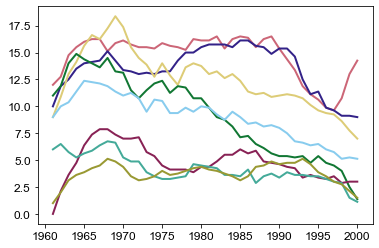

In [229]:
DT = np.diff(T, axis = 0)
V = DT.sum(axis = 1)

def smooth(x,window_len=11,window='flat'):
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:  
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]



k = 0
for i in range(n):
    long_name = labels[i]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:
            y = smooth(V[:,i], window_len = 8)
            plt.plot(timesteps[1:], y, color = cset_muted[k], alpha = 1, linewidth = 2, label = name)
            k += 1
        

# plt.imshow(DT.sum(axis = 1))

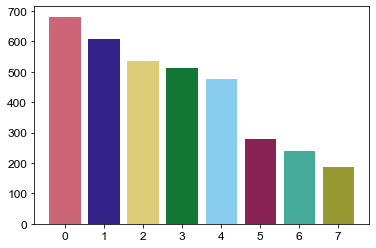

In [198]:
M = T[-1].copy()
V = M.sum(axis = 0)

V1 = V - np.diag(M)

bars = np.zeros(8)
labs = []

k = 0
for i in range(n):
    long_name = labels[i]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:
            bars[k] = V[i]
            labs.append(name)
            # plt.bar(k, V[i], label = name, color = cset_muted[k])
            k += 1

labs = np.array(labs)[np.argsort(-bars)]
colors = np.array(cset_muted)[np.argsort(-bars)]
bars = -np.sort(-bars)

for k in range(8):
    plt.bar(k, bars[k], label = labs[k], color = cset_muted[k])

# plt.bar(np.arange(n), T[-1].sum(axis = 1), color = 'grey')

[Text(0, 0.5, 'Internal Placements'), Text(0.5, 0, 'External Placements')]

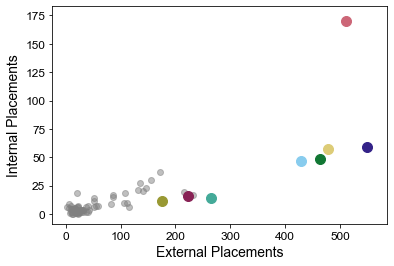

In [199]:
fig = plt.figure()
ax = fig.add_subplot(111)

M = T[-1].copy().T
V = M.sum(axis = 1)

V1 = V - np.diag(M)
V2 = np.diag(M)


bars = np.zeros(8)
labs = []

plt.scatter(V1, V2, color = 'grey', alpha = .5)

k = 0
for i in range(n):
    long_name = labels[i]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:
            plt.scatter(V1[i], V2[i], color = cset_muted[k], s = 100)
            # plt.bar(k, V[i], label = name, color = cset_muted[k])
            k += 1


ax.set(xlabel = 'External Placements', ylabel = 'Internal Placements')

# labs = np.array(labs)[np.argsort(-bars)]
# colors = np.array(cset_muted)[np.argsort(-bars)]
# bars = -np.sort(-bars)

# for k in range(8):
#     plt.bar(k, bars[k], label = labs[k], color = cset_muted[k])

# # plt.bar(np.arange(n), T[-1].sum(axis = 1), color = 'grey')

(-0.9368966643677424,
 1.095731602517895,
 -0.9614903215685786,
 0.9760444407484419)

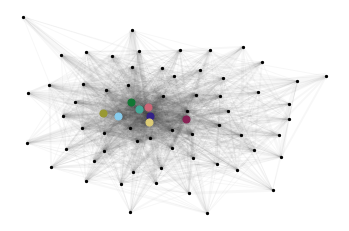

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111)

M = T[20]
np.fill_diagonal(M, 0)

# M = M + M.T

G = nx.from_numpy_array(M, parallel_edges = False)

pos = nx.spring_layout(G)

weight_map = [e[2]['weight'] for e in G.edges(data = True)]

nx.draw_networkx_edges(G, pos, 
                        ax = ax, 
                        edge_color = 'black', 
                        width = weight_map,
                        alpha = .03,
                        edge_cmap=plt.cm.Greys)
nx.draw_networkx_nodes(G, pos, ax = ax, node_size = 5, node_color = 'black')

k = 0
for i in range(n):
    long_name = labels[i]
    if long_name in shortener: 
        name = shortener[long_name]
        if name in highlight:
            plt.scatter(pos[i][0],pos[i][1], color = cset_muted[k], zorder = 10, s = 50)
            k += 1
ax.axis('off')

In [169]:
T[-1]

array([[170.,  21.,  25., ...,   0.,   0.,   0.],
       [ 30.,  59.,  27., ...,   0.,   0.,   0.],
       [ 29.,  29.,  57., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   6.,   0.,   0.],
       [  1.,   1.,   1., ...,   0.,   9.,   0.],
       [  8.,   5.,   4., ...,   0.,   1.,   4.]])